In [31]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import root_mean_squared_error, r2_score
from datetime import datetime, timedelta, date


In [2]:
all_df = pd.read_csv("../../data/processed/raw_datetime_comptage.csv", index_col=0)
all_df.head()

,Nom du compteur,Comptage horaire,Date et heure de comptage
12886,106 avenue Denfert Rochereau NE-SO,3166,2023-06-14 14:00:00+02:00
685401,Quai d'Orsay O-E,3070,2025-01-05 15:00:00+01:00
667057,Totem Cours la Reine O-E,3010,2023-06-20 23:00:00+02:00
12622,106 avenue Denfert Rochereau NE-SO,2925,2023-06-02 16:00:00+02:00
12680,106 avenue Denfert Rochereau NE-SO,2887,2023-06-16 05:00:00+02:00


In [3]:
all_df["Date et heure de comptage"] = pd.to_datetime(all_df["Date et heure de comptage"], utc=True)
all_df["Date et heure de comptage"] = all_df["Date et heure de comptage"].dt.tz_convert("Europe/Paris")
all_df["Date et heure de comptage"] = all_df["Date et heure de comptage"].dt.tz_localize(None)

In [4]:
compteurs = list(all_df["Nom du compteur"].unique())

In [5]:
compteurs_dfs = {}
for c in all_df["Nom du compteur"].unique():
    compteurs_dfs[c] = all_df.loc[all_df["Nom du compteur"] == c].drop(columns=["Nom du compteur"]).rename(columns={"Date et heure de comptage": "ds", "Comptage horaire": "y"})


In [6]:
compteur = compteurs[2]
print(compteur)

Totem Cours la Reine O-E


In [41]:
df = compteurs_dfs[compteur].sort_values(by="ds")

In [42]:
df_train = df.loc[df.ds.dt.year < 2025]
df_test = df.loc[df.ds.dt.year == 2025]

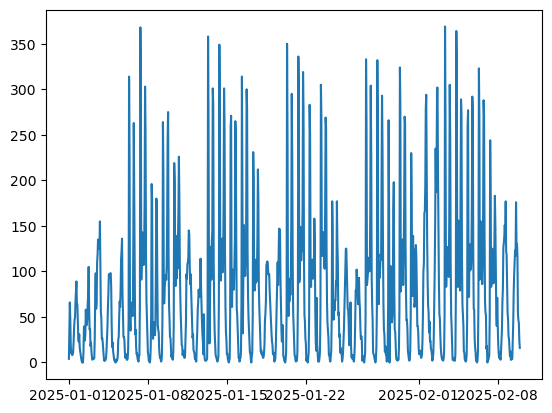

In [43]:
plt.plot(df_test.ds, df_test.y)

In [12]:
def list_dates(begin, end):
    start_date = date.fromisoformat(begin)
    end_date = date.fromisoformat(end)
    
    current_date = start_date
    liste = []
    while current_date <= end_date:
        liste.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return liste


In [15]:
vacances = [
    ("2022-12-17", "2023-01-03"),
    ("2023-02-18", "2023-03-06"),
    ("2023-04-22", "2023-05-09"),
    ("2023-07-08", "2023-09-03"),
    ("2023-10-21", "2023-11-06"),
    ("2023-12-24", "2024-01-08"),
    ("2024-02-10", "2024-02-26"),
    ("2024-04-06", "2024-04-22"),
    ("2024-05-08", "2024-05-13"),
    ("2024-07-06", "2024-09-02"),
    ("2024-10-19", "2024-11-04"),
    ("2024-12-21", "2025-01-05"),
    ("2025-02-15", "2025-03-02"),
    ("2025-04-12", "2025-04-27"),
    ("2025-07-05", "2025-08-31"),
    ("2025-10-18", "2025-11-02"),
    ("2025-12-20", "2026-01-04"),
]
dates = []
for b, e in vacances:
    dates += list_dates(b, e)

vacances_df = pd.DataFrame({
  'holiday': 'vacances',
  'ds': pd.to_datetime(dates),
})


In [70]:
prophet = Prophet(
    seasonality_mode='additive',
    growth='flat',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
)


In [71]:
prophet.add_country_holidays(country_name="FR")

In [72]:
prophet.fit(df_train)

12:18:44 - cmdstanpy - INFO - Chain [1] start processing
12:18:45 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
future = prophet.make_future_dataframe(periods=14*24, freq='h')
future.tail()

,ds
17839,2025-01-14 19:00:00
17840,2025-01-14 20:00:00
17841,2025-01-14 21:00:00
17842,2025-01-14 22:00:00
17843,2025-01-14 23:00:00


In [74]:
forecast = prophet.predict(future)

In [75]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints' Day,All Saints' Day_lower,All Saints' Day_upper,Armistice Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
17839,2025-01-14 19:00:00,78.773807,61.637579,306.889906,78.773807,78.773807,0.0,0.0,0.0,0.0,...,15.043181,15.043181,15.043181,1.093452,1.093452,1.093452,0.0,0.0,0.0,176.492974
17840,2025-01-14 20:00:00,78.773807,20.278091,251.699319,78.773807,78.773807,0.0,0.0,0.0,0.0,...,15.030667,15.030667,15.030667,1.157972,1.157972,1.157972,0.0,0.0,0.0,140.675296
17841,2025-01-14 21:00:00,78.773807,-34.545615,225.205672,78.773807,78.773807,0.0,0.0,0.0,0.0,...,15.007219,15.007219,15.007219,1.222770,1.222770,1.222770,0.0,0.0,0.0,90.612848
17842,2025-01-14 22:00:00,78.773807,-75.231793,165.556124,78.773807,78.773807,0.0,0.0,0.0,0.0,...,14.974658,14.974658,14.974658,1.287847,1.287847,1.287847,0.0,0.0,0.0,50.222459
17843,2025-01-14 23:00:00,78.773807,-92.565259,151.354638,78.773807,78.773807,0.0,0.0,0.0,0.0,...,14.934722,14.934722,14.934722,1.353203,1.353203,1.353203,0.0,0.0,0.0,35.656763


/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


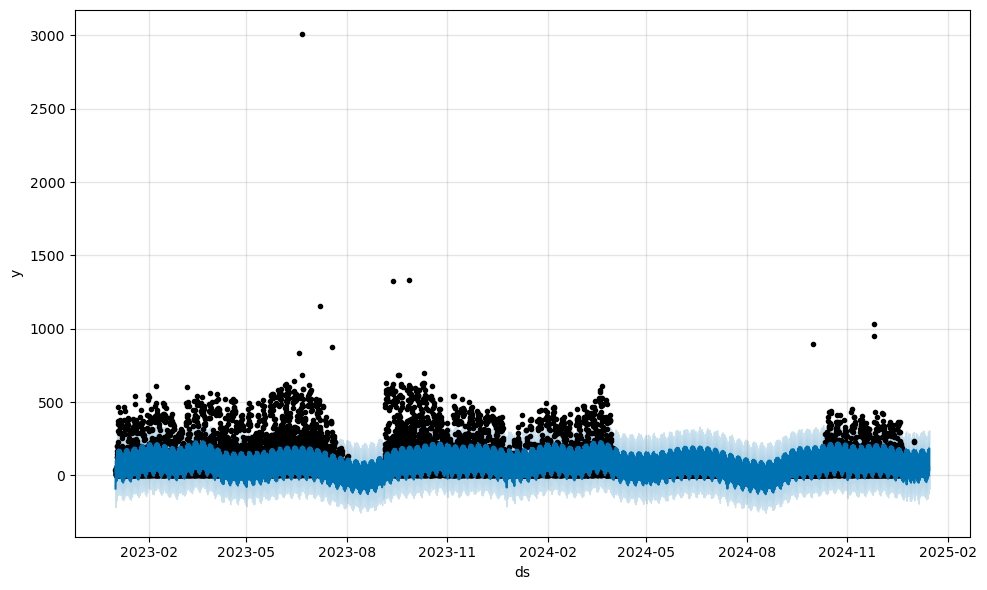

In [76]:
prophet.plot(forecast);

/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/opt/anaconda3/envs/prophet_venv/lib/python3.9/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects

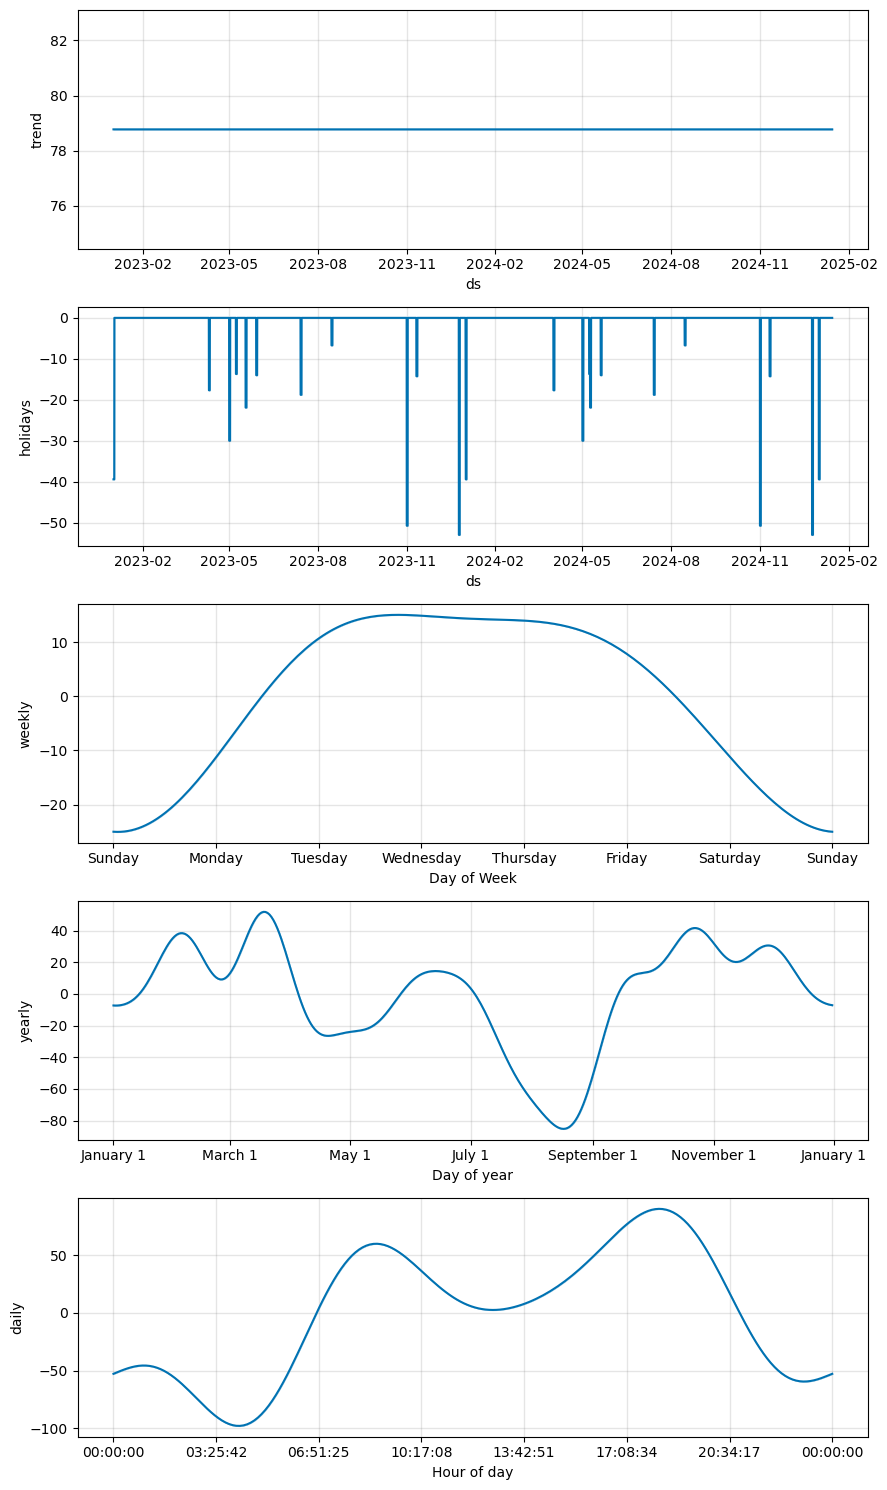

In [77]:
prophet.plot_components(forecast);

In [78]:
rmse = root_mean_squared_error(df_test['y'].iloc[:336], forecast['yhat'].loc[forecast.ds.dt.year == 2025])
print(f'Erreur quadratique moyenne (RMSE) : {rmse}')

Erreur quadratique moyenne (RMSE) : 52.42574674512588


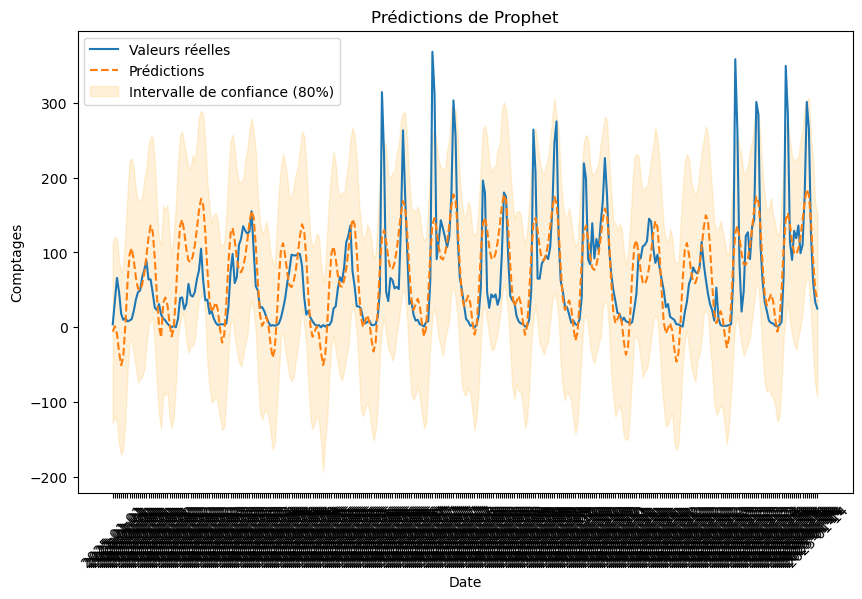

In [79]:
plt.figure(figsize=(10, 6))
x = df_test['ds'].iloc[:336]
df_y = df.loc[df.ds.dt.year == 2025].iloc[:336].y
pred_y = forecast['yhat'].loc[forecast.ds.dt.year == 2025]
plt.plot(x, df_y, label='Valeurs réelles')
plt.plot(x, pred_y, label='Prédictions', linestyle='--')
plt.fill_between(x, forecast['yhat_lower'].loc[forecast.ds.dt.year == 2025], forecast['yhat_upper'].loc[forecast.ds.dt.year == 2025],
color='orange', alpha=0.15, label='Intervalle de confiance (80%)')
plt.title('Prédictions de Prophet')
plt.xlabel('Date')
plt.xticks(x, rotation=45)
plt.ylabel('Comptages')
plt.legend();

In [32]:
def prophet_compteur(compteur):
    print(compteur)
    df = compteurs_dfs[compteur].sort_values(by="ds")
    df_train = df.loc[df.ds.dt.year < 2025]
    df_test = df.loc[df.ds.dt.year == 2025]
    prophet = Prophet(
        seasonality_mode='additive',
        growth='flat',
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        holidays=vacances_df,
    )
    prophet.add_country_holidays(country_name="FR")
    prophet.fit(df_train)
    forecast = prophet.predict(df_test)
    r2_test = r2_score(df_test['y'], forecast['yhat'])
    rmse = root_mean_squared_error(df_test['y'], forecast['yhat'])
    print(f'R2 score test : {r2_test}')
    print(f'Erreur quadratique moyenne (RMSE) : {rmse}')
    return r2_test, rmse

In [29]:
for c in compteurs_dfs:
    if c in compteurs and len(compteurs_dfs[c].loc[compteurs_dfs[c].ds.dt.year == 2025]) == 0:
        compteurs.remove(c)

In [39]:
rmsel = []
r2l = []
for c in compteurs:
    r2, rmse = prophet_compteur(c)
    r2l.append(r2)
    rmsel.append(rmse)


106 avenue Denfert Rochereau NE-SO


12:01:50 - cmdstanpy - INFO - Chain [1] start processing
12:01:50 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.0
Erreur quadratique moyenne (RMSE) : 44.06101521090034
Quai d'Orsay O-E


12:01:51 - cmdstanpy - INFO - Chain [1] start processing
12:01:51 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.19388754001286646
Erreur quadratique moyenne (RMSE) : 116.43832666697232
Totem Cours la Reine O-E


12:01:52 - cmdstanpy - INFO - Chain [1] start processing
12:01:52 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4823014499474084
Erreur quadratique moyenne (RMSE) : 57.06402315142515
132 rue Lecourbe NE-SO


12:01:53 - cmdstanpy - INFO - Chain [1] start processing
12:01:53 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6128706044048504
Erreur quadratique moyenne (RMSE) : 27.176662764539397
Totem 64 Rue de Rivoli O-E


12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6827019580516481
Erreur quadratique moyenne (RMSE) : 92.19723741259332
Totem 73 boulevard de Sébastopol S-N


12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:56 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.7021006954150573
Erreur quadratique moyenne (RMSE) : 123.70786137176476
Quai d'Orsay E-O


12:01:56 - cmdstanpy - INFO - Chain [1] start processing
12:01:57 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.06544202350972095
Erreur quadratique moyenne (RMSE) : 94.08510290005057
Totem 64 Rue de Rivoli E-O


12:01:57 - cmdstanpy - INFO - Chain [1] start processing
12:01:58 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5581590886023667
Erreur quadratique moyenne (RMSE) : 98.21867007244447
Quai des Tuileries NO-SE


12:01:59 - cmdstanpy - INFO - Chain [1] start processing
12:01:59 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.564833982987567
Erreur quadratique moyenne (RMSE) : 57.744530228927076
Totem 73 boulevard de Sébastopol N-S


12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.515968123016719
Erreur quadratique moyenne (RMSE) : 105.69579398815748
Totem Cours la Reine E-O


12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : -0.06586444856224838
Erreur quadratique moyenne (RMSE) : 29.947752214524915
Pont des Invalides N-S


12:02:02 - cmdstanpy - INFO - Chain [1] start processing
12:02:02 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.572087344778242
Erreur quadratique moyenne (RMSE) : 27.09909475085129
27 quai de la Tournelle SE-NO


12:02:03 - cmdstanpy - INFO - Chain [1] start processing
12:02:03 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5586313880844516
Erreur quadratique moyenne (RMSE) : 82.65768014790235
Voie Georges Pompidou SO-NE


12:02:04 - cmdstanpy - INFO - Chain [1] start processing
12:02:04 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.42577517489982153
Erreur quadratique moyenne (RMSE) : 66.4304231752889
102 boulevard de Magenta SE-NO


12:02:05 - cmdstanpy - INFO - Chain [1] start processing
12:02:05 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6760715336150128
Erreur quadratique moyenne (RMSE) : 75.67514025484164
72 boulevard Voltaire NO-SE


12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6926639338562757
Erreur quadratique moyenne (RMSE) : 68.88188248121351
Quai des Tuileries SE-NO


12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:08 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.3311199513278562
Erreur quadratique moyenne (RMSE) : 67.15451272527743
Pont Charles De Gaulle SO-NE


12:02:09 - cmdstanpy - INFO - Chain [1] start processing
12:02:09 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5693971057747353
Erreur quadratique moyenne (RMSE) : 31.74734113513284
67 boulevard Voltaire SE-NO


12:02:10 - cmdstanpy - INFO - Chain [1] start processing
12:02:10 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5330792805476273
Erreur quadratique moyenne (RMSE) : 84.8175918306032
89 boulevard de Magenta NO-SE


12:02:11 - cmdstanpy - INFO - Chain [1] start processing
12:02:11 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6034214758785437
Erreur quadratique moyenne (RMSE) : 90.63970089745871
Pont Charles De Gaulle NE-SO


12:02:12 - cmdstanpy - INFO - Chain [1] start processing
12:02:12 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4892950103497129
Erreur quadratique moyenne (RMSE) : 35.47240246166298
33 avenue des Champs Elysées NO-SE


12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5444174934663619
Erreur quadratique moyenne (RMSE) : 58.6791102331639
38 rue Turbigo SO-NE


12:02:14 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6115018771162404
Erreur quadratique moyenne (RMSE) : 71.58769294201971
Face au 48 quai de la marne NE-SO


12:02:15 - cmdstanpy - INFO - Chain [1] start processing
12:02:15 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.48335610093349335
Erreur quadratique moyenne (RMSE) : 55.78513221291489
72 boulevard Richard Lenoir S-N


12:02:16 - cmdstanpy - INFO - Chain [1] start processing
12:02:17 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5731754040692184
Erreur quadratique moyenne (RMSE) : 64.83300555400788
18 quai de l'Hôtel de Ville SE-NO


12:02:17 - cmdstanpy - INFO - Chain [1] start processing
12:02:18 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4865589357388108
Erreur quadratique moyenne (RMSE) : 18.57034651022294
38 rue Turbigo NE-SO


12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4733902594959031
Erreur quadratique moyenne (RMSE) : 70.82457605162645
Pont National NE-SO


12:02:20 - cmdstanpy - INFO - Chain [1] start processing
12:02:20 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4759155528476725
Erreur quadratique moyenne (RMSE) : 56.9978215629054
35 boulevard de Ménilmontant NO-SE


12:02:21 - cmdstanpy - INFO - Chain [1] start processing
12:02:21 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6122965931818874
Erreur quadratique moyenne (RMSE) : 74.19569555446718
77 boulevard Richard Lenoir N-S


12:02:22 - cmdstanpy - INFO - Chain [1] start processing
12:02:22 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5025458785575109
Erreur quadratique moyenne (RMSE) : 64.82230075204517
Pont de la Concorde N-S


12:02:23 - cmdstanpy - INFO - Chain [1] start processing
12:02:23 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.581570170723909
Erreur quadratique moyenne (RMSE) : 64.09571863591641
44 avenue des Champs Elysées SE-NO


12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.507567921285309
Erreur quadratique moyenne (RMSE) : 50.639980475222224
Totem 85 quai d'Austerlitz SE-NO


12:02:25 - cmdstanpy - INFO - Chain [1] start processing
12:02:25 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4881444755466573
Erreur quadratique moyenne (RMSE) : 62.94667643502717
Pont des Invalides S-N


12:02:26 - cmdstanpy - INFO - Chain [1] start processing
12:02:26 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4886058672062278
Erreur quadratique moyenne (RMSE) : 43.12341301092768
10 avenue de la Grande Armée SE-NO


12:02:27 - cmdstanpy - INFO - Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.0
Erreur quadratique moyenne (RMSE) : 23.157279833037194
27 quai de la Tournelle NO-SE


12:02:28 - cmdstanpy - INFO - Chain [1] start processing
12:02:28 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5973490328354465
Erreur quadratique moyenne (RMSE) : 42.33422070178762
Pont de la Concorde S-N


12:02:29 - cmdstanpy - INFO - Chain [1] start processing
12:02:29 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6074706385248945
Erreur quadratique moyenne (RMSE) : 61.04960696760759
6 rue Julia Bartet SO-NE


12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.48167629590081984
Erreur quadratique moyenne (RMSE) : 48.98906976702577
Face au 70 quai de Bercy S-N


12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:32 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4937345141193764
Erreur quadratique moyenne (RMSE) : 39.65127187567498
Face au 48 quai de la marne SO-NE


12:02:33 - cmdstanpy - INFO - Chain [1] start processing
12:02:33 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5199201875434725
Erreur quadratique moyenne (RMSE) : 52.2357826745289
36 quai de Grenelle NE-SO


12:02:34 - cmdstanpy - INFO - Chain [1] start processing
12:02:34 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5459571989476518
Erreur quadratique moyenne (RMSE) : 46.990697483506786
163 boulevard Brune SE-NO


12:02:35 - cmdstanpy - INFO - Chain [1] start processing
12:02:35 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4783823156758037
Erreur quadratique moyenne (RMSE) : 53.519253676617424
51 boulevard du Général Martial Valin SE-NO


12:02:36 - cmdstanpy - INFO - Chain [1] start processing
12:02:36 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5215547470875981
Erreur quadratique moyenne (RMSE) : 43.82889663608205
24 boulevard Jourdan E-O


12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.0
Erreur quadratique moyenne (RMSE) : 72.71583208648102
243 boulevard Saint Germain NO-SE


12:02:38 - cmdstanpy - INFO - Chain [1] start processing
12:02:38 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6137623574824624
Erreur quadratique moyenne (RMSE) : 35.225339250410194
Totem 85 quai d'Austerlitz NO-SE


12:02:39 - cmdstanpy - INFO - Chain [1] start processing
12:02:39 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6002536087011952
Erreur quadratique moyenne (RMSE) : 42.51363868939726
6 rue Julia Bartet NE-SO


12:02:40 - cmdstanpy - INFO - Chain [1] start processing
12:02:40 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6197868539895858
Erreur quadratique moyenne (RMSE) : 36.80410393743665
87 avenue de Flandre NE-SO


12:02:41 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6917300433559839
Erreur quadratique moyenne (RMSE) : 49.301946498463515
Face au 70 quai de Bercy N-S


12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5905292144426637
Erreur quadratique moyenne (RMSE) : 32.704432460380204
56 boulevard Kellermann E-O


12:02:43 - cmdstanpy - INFO - Chain [1] start processing
12:02:44 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.49977076422656197
Erreur quadratique moyenne (RMSE) : 40.17895709990173
77 boulevard Masséna SO-NE


12:02:45 - cmdstanpy - INFO - Chain [1] start processing
12:02:45 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5047188125481291
Erreur quadratique moyenne (RMSE) : 38.87367015506658
135 avenue Daumesnil SE-NO


12:02:46 - cmdstanpy - INFO - Chain [1] start processing
12:02:46 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5046559478353281
Erreur quadratique moyenne (RMSE) : 35.792159993902864
9 boulevard Jourdan O-E


12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:47 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.540189423504143
Erreur quadratique moyenne (RMSE) : 43.66074638264686
Pont de Bercy SO-NE


12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6252069334940578
Erreur quadratique moyenne (RMSE) : 26.26364551994678
27 boulevard Diderot E-O


12:02:49 - cmdstanpy - INFO - Chain [1] start processing
12:02:49 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.49948110124213085
Erreur quadratique moyenne (RMSE) : 34.19348963781989
147 avenue d'Italie S-N


12:02:50 - cmdstanpy - INFO - Chain [1] start processing
12:02:50 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6015465254584471
Erreur quadratique moyenne (RMSE) : 23.015728391529866
Pont du Garigliano NO-SE


12:02:51 - cmdstanpy - INFO - Chain [1] start processing
12:02:52 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5733317623387277
Erreur quadratique moyenne (RMSE) : 37.64372281781875
Pont de Bercy NE-SO


12:02:52 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5031987832097757
Erreur quadratique moyenne (RMSE) : 35.403571872004036
36 quai de Grenelle SO-NE


12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5038013103865486
Erreur quadratique moyenne (RMSE) : 37.96704434559762
Pont du Garigliano SE-NO


12:02:55 - cmdstanpy - INFO - Chain [1] start processing
12:02:55 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4868024742075825
Erreur quadratique moyenne (RMSE) : 36.6353433229893
Face 104 rue d'Aubervilliers N-S


12:02:56 - cmdstanpy - INFO - Chain [1] start processing
12:02:56 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.7371921161235091
Erreur quadratique moyenne (RMSE) : 27.26596611907067
39 quai François Mauriac SE-NO


12:02:57 - cmdstanpy - INFO - Chain [1] start processing
12:02:57 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.578274717036574
Erreur quadratique moyenne (RMSE) : 38.68381692537932
Face 104 rue d'Aubervilliers S-N


12:02:58 - cmdstanpy - INFO - Chain [1] start processing
12:02:58 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.47738194363297515
Erreur quadratique moyenne (RMSE) : 29.36272549723663
Face au 25 quai de l'Oise NE-SO


12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6933683270887516
Erreur quadratique moyenne (RMSE) : 28.57376819425638
Face au 4 avenue de la porte de Bagnolet E-O


12:03:00 - cmdstanpy - INFO - Chain [1] start processing
12:03:01 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5741388700204777
Erreur quadratique moyenne (RMSE) : 30.74440700884945
Face au 25 quai de l'Oise SO-NE


12:03:02 - cmdstanpy - INFO - Chain [1] start processing
12:03:02 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.42859818581356257
Erreur quadratique moyenne (RMSE) : 32.7686574383644
39 quai François Mauriac NO-SE


12:03:03 - cmdstanpy - INFO - Chain [1] start processing
12:03:03 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5487441513086937
Erreur quadratique moyenne (RMSE) : 35.5148310490164
Pont National SO-NE


12:03:04 - cmdstanpy - INFO - Chain [1] start processing
12:03:04 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.3422104415095385
Erreur quadratique moyenne (RMSE) : 34.02160584009616
Face au 49 boulevard du Général Martial Valin NO-SE


12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5080214949371586
Erreur quadratique moyenne (RMSE) : 35.93669767994406
98 boulevard Poniatowski SO-NE


12:03:06 - cmdstanpy - INFO - Chain [1] start processing
12:03:06 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.577608791921659
Erreur quadratique moyenne (RMSE) : 28.763893106477074
Voie Georges Pompidou NE-SO


12:03:07 - cmdstanpy - INFO - Chain [1] start processing
12:03:07 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5247663790820825
Erreur quadratique moyenne (RMSE) : 28.414069052497272
Face au 8 avenue de la porte de Charenton SE-NO


12:03:08 - cmdstanpy - INFO - Chain [1] start processing
12:03:08 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : -635.1379357340262
Erreur quadratique moyenne (RMSE) : 34.26650788035365
98 boulevard Poniatowski NE-SO


12:03:09 - cmdstanpy - INFO - Chain [1] start processing
12:03:09 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.48267754281147457
Erreur quadratique moyenne (RMSE) : 27.73930954006154
129 rue Lecourbe SO-NE


12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5811913661090623
Erreur quadratique moyenne (RMSE) : 28.609518369301888
72 boulevard Brune NO-SE


12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:12 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5380674625429346
Erreur quadratique moyenne (RMSE) : 32.29757087304717
42 boulevard Soult S-N


12:03:12 - cmdstanpy - INFO - Chain [1] start processing
12:03:13 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5506627320986237
Erreur quadratique moyenne (RMSE) : 31.07470365788495
72 avenue de Flandre SO-NE


12:03:14 - cmdstanpy - INFO - Chain [1] start processing
12:03:14 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.540134011186056
Erreur quadratique moyenne (RMSE) : 39.8384833748339
7 avenue de la Grande Armée NO-SE


12:03:15 - cmdstanpy - INFO - Chain [1] start processing
12:03:15 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5462492882176988
Erreur quadratique moyenne (RMSE) : 23.572204706267446
16 avenue de la Porte des Ternes E-O


12:03:16 - cmdstanpy - INFO - Chain [1] start processing
12:03:16 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4342408942013557
Erreur quadratique moyenne (RMSE) : 21.215999668883786
152 boulevard du Montparnasse O-E


12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6270031798952578
Erreur quadratique moyenne (RMSE) : 25.671576586257128
42 boulevard Soult N-S


12:03:18 - cmdstanpy - INFO - Chain [1] start processing
12:03:18 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5214278322084365
Erreur quadratique moyenne (RMSE) : 24.803583011428014
180 avenue d'Italie N-S


12:03:19 - cmdstanpy - INFO - Chain [1] start processing
12:03:19 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6022073713267638
Erreur quadratique moyenne (RMSE) : 23.169414165997292
28 boulevard Diderot O-E


12:03:20 - cmdstanpy - INFO - Chain [1] start processing
12:03:20 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6117126698141961
Erreur quadratique moyenne (RMSE) : 20.421497155287927
18 quai de l'Hôtel de Ville NO-SE


12:03:21 - cmdstanpy - INFO - Chain [1] start processing
12:03:22 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5887377048911946
Erreur quadratique moyenne (RMSE) : 13.56710076271724
Face au 16 avenue de la  Porte des Ternes O-E


12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.44013875761683396
Erreur quadratique moyenne (RMSE) : 20.513737664069936
152 boulevard du Montparnasse E-O


12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.6413688018248411
Erreur quadratique moyenne (RMSE) : 23.841677630870382
Face au 40 quai D'Issy SO-NE


12:03:25 - cmdstanpy - INFO - Chain [1] start processing
12:03:25 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.4710474622224238
Erreur quadratique moyenne (RMSE) : 17.37101215588296
10 boulevard Auguste Blanqui NE-SO


12:03:26 - cmdstanpy - INFO - Chain [1] start processing
12:03:26 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5876962479683311
Erreur quadratique moyenne (RMSE) : 22.389252139623807
81 boulevard Mortier N-S


12:03:27 - cmdstanpy - INFO - Chain [1] start processing
12:03:27 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5703474186889124
Erreur quadratique moyenne (RMSE) : 15.610809627041878
Face au 40 quai D'Issy NE-SO


12:03:28 - cmdstanpy - INFO - Chain [1] start processing
12:03:28 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.507231842200839
Erreur quadratique moyenne (RMSE) : 21.612417731275926
21 boulevard Auguste Blanqui SO-NE


12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5440543957683845
Erreur quadratique moyenne (RMSE) : 23.986269212221295
Face au 4 avenue de la porte de Bagnolet O-E


12:03:30 - cmdstanpy - INFO - Chain [1] start processing
12:03:31 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.667825358502661
Erreur quadratique moyenne (RMSE) : 16.478605583918615
77 boulevard Masséna NE-SO


12:03:31 - cmdstanpy - INFO - Chain [1] start processing
12:03:32 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5905119777004775
Erreur quadratique moyenne (RMSE) : 12.25950461569961
27 boulevard Davout N-S


12:03:33 - cmdstanpy - INFO - Chain [1] start processing
12:03:33 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.5111741616770753
Erreur quadratique moyenne (RMSE) : 15.149730037115189
28 boulevard Diderot E-O


12:03:34 - cmdstanpy - INFO - Chain [1] start processing
12:03:34 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : -0.5315214770605303
Erreur quadratique moyenne (RMSE) : 30.944664090800334
81 boulevard Mortier S-N


12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : 0.46669601867071575
Erreur quadratique moyenne (RMSE) : 12.490904221894157
Face au 8 avenue de la porte de Charenton NO-SE


12:03:36 - cmdstanpy - INFO - Chain [1] start processing
12:03:36 - cmdstanpy - INFO - Chain [1] done processing


R2 score test : -18.933563242349223
Erreur quadratique moyenne (RMSE) : 17.21612422639083


In [43]:
np.mean(rmsel)

43.822951386092534

In [44]:
np.median(r2l)

0.5380674625429346